In [43]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [44]:
path = "Images"
annot = "Airplanes_Annotations"

airplane_339.jpg


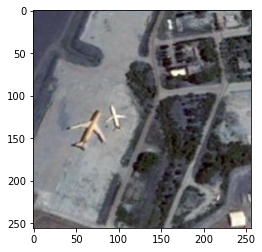

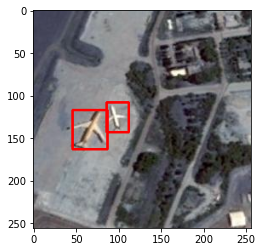

In [45]:
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

In [46]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

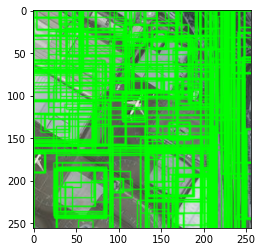

In [47]:
im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [49]:
train_images=[]
train_labels=[]

In [50]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [51]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

0 airplane_339.jpg
here2
here2
here2
here2
here2
here
here
here
here
here


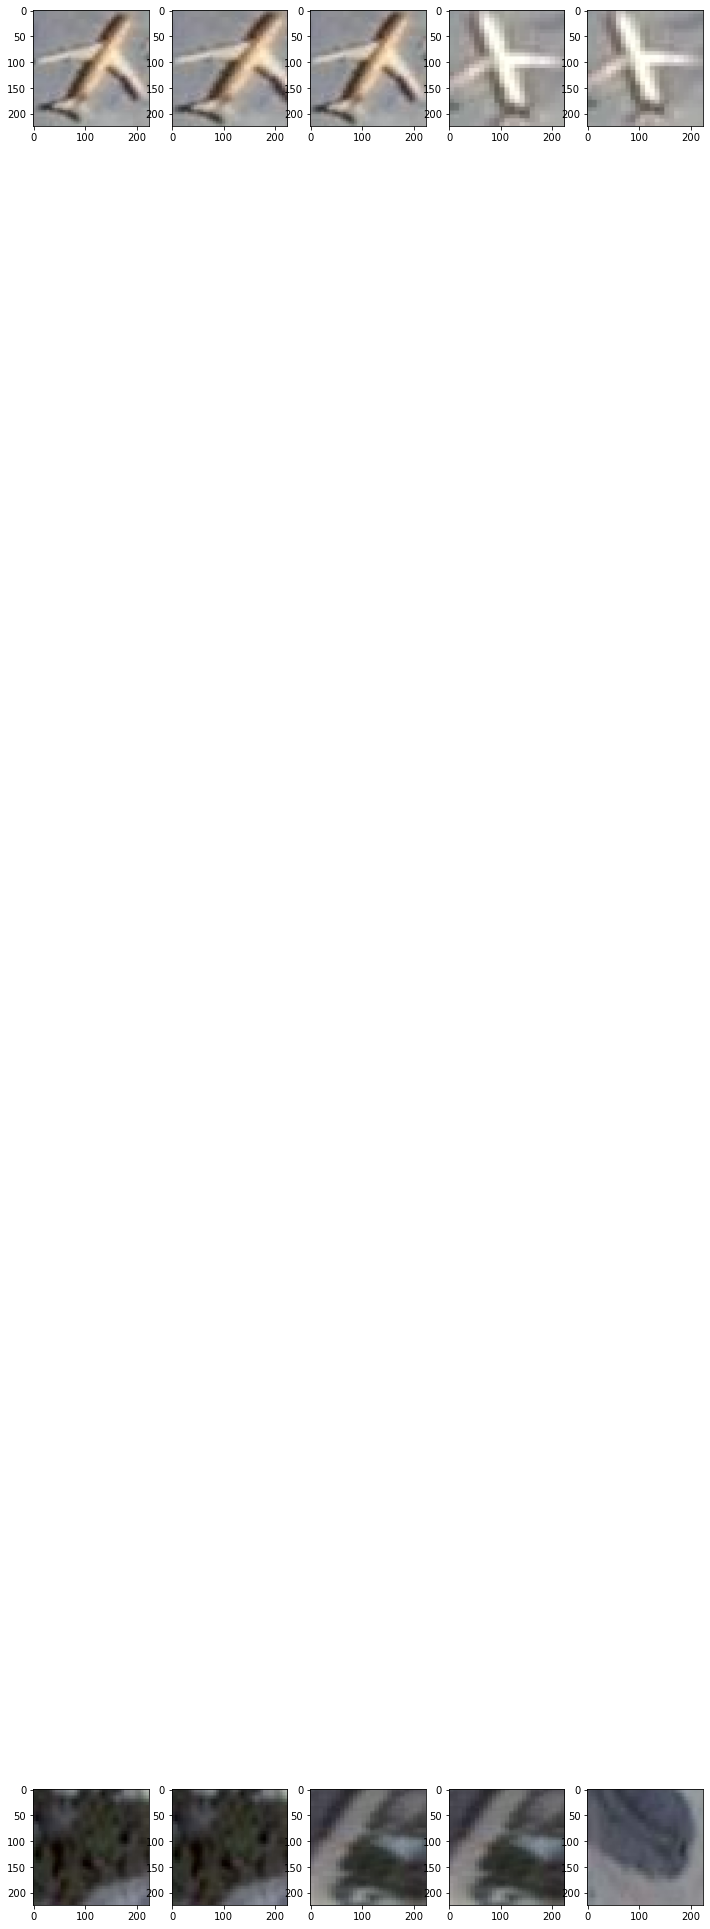

1 airplane_682.jpg
2 airplane_450.jpg
3 airplane_074.jpg
4 airplane_022.jpg
5 airplane_246.jpg
6 airplane_348.jpg
7 airplane_342.jpg
8 airplane_693.jpg
9 airplane_184.jpg


KeyboardInterrupt: 

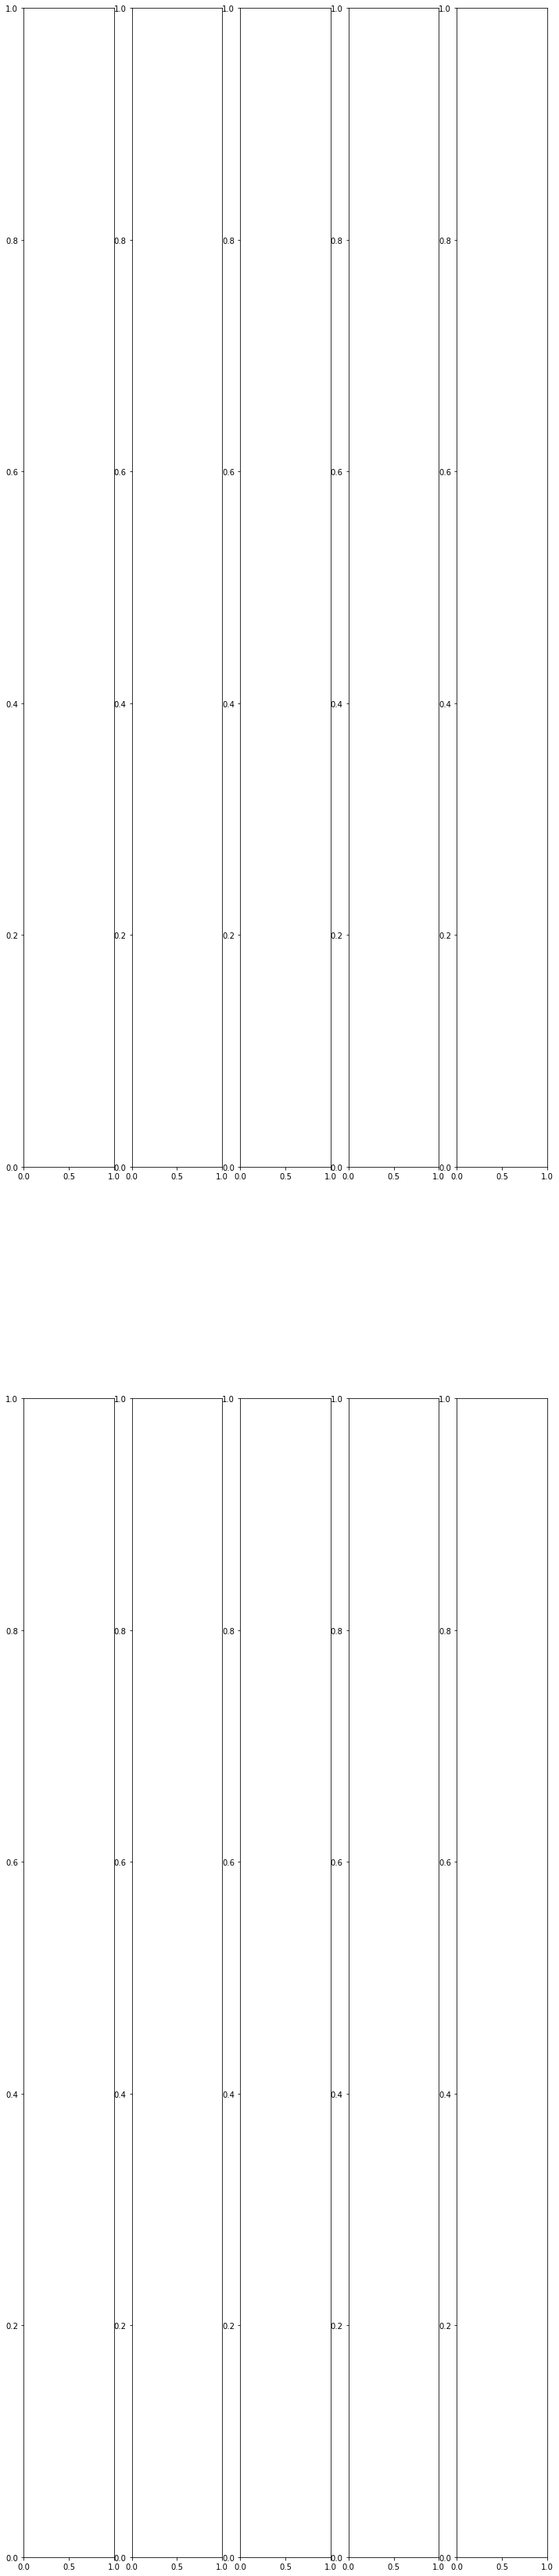

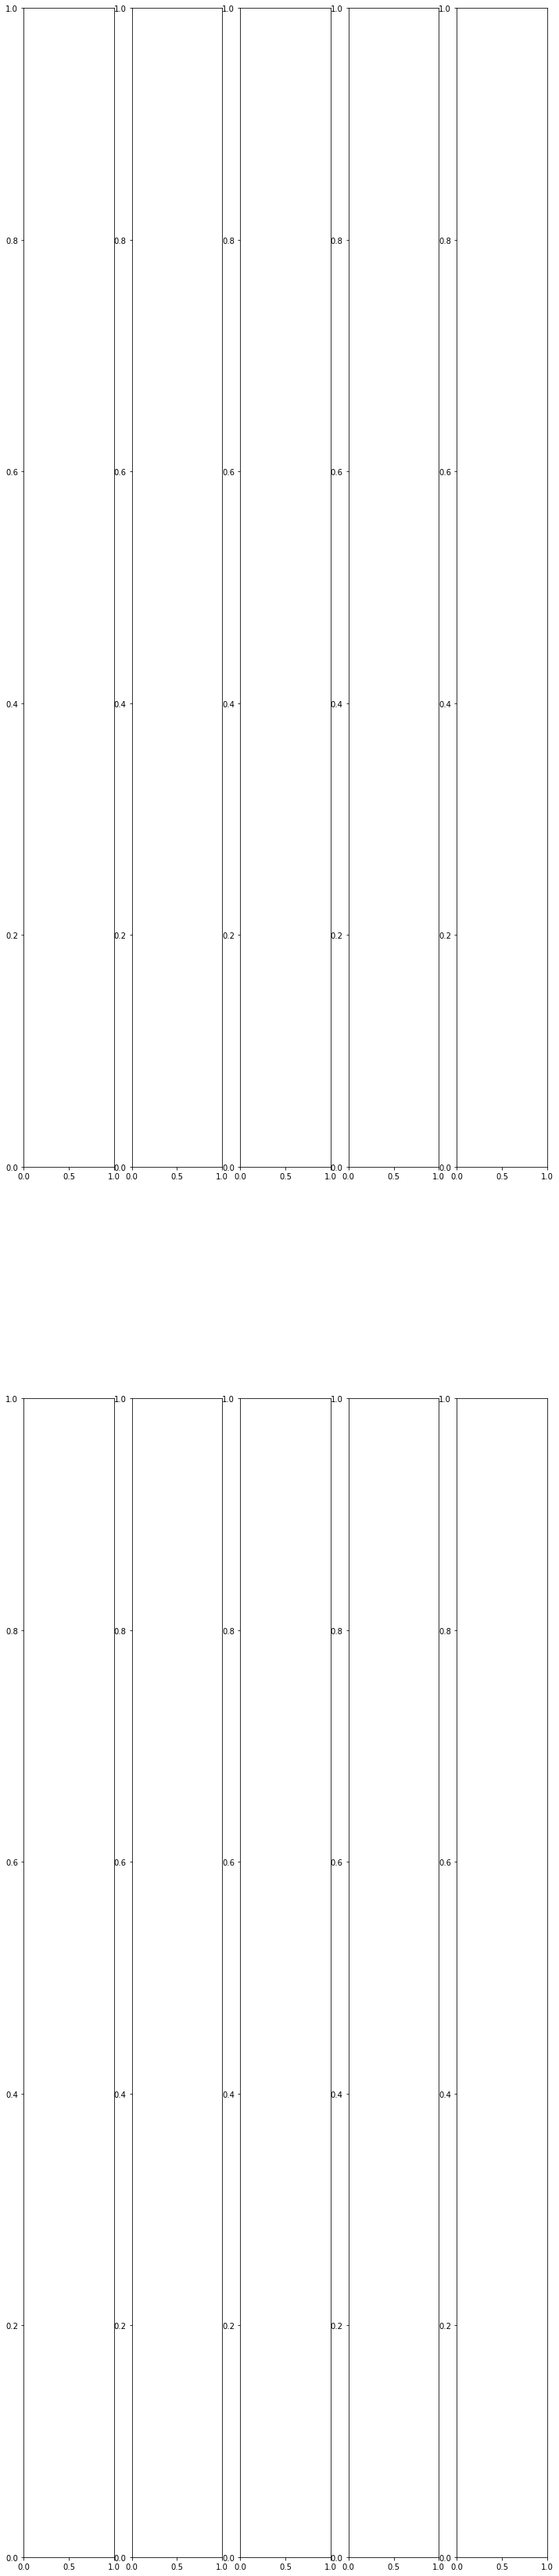

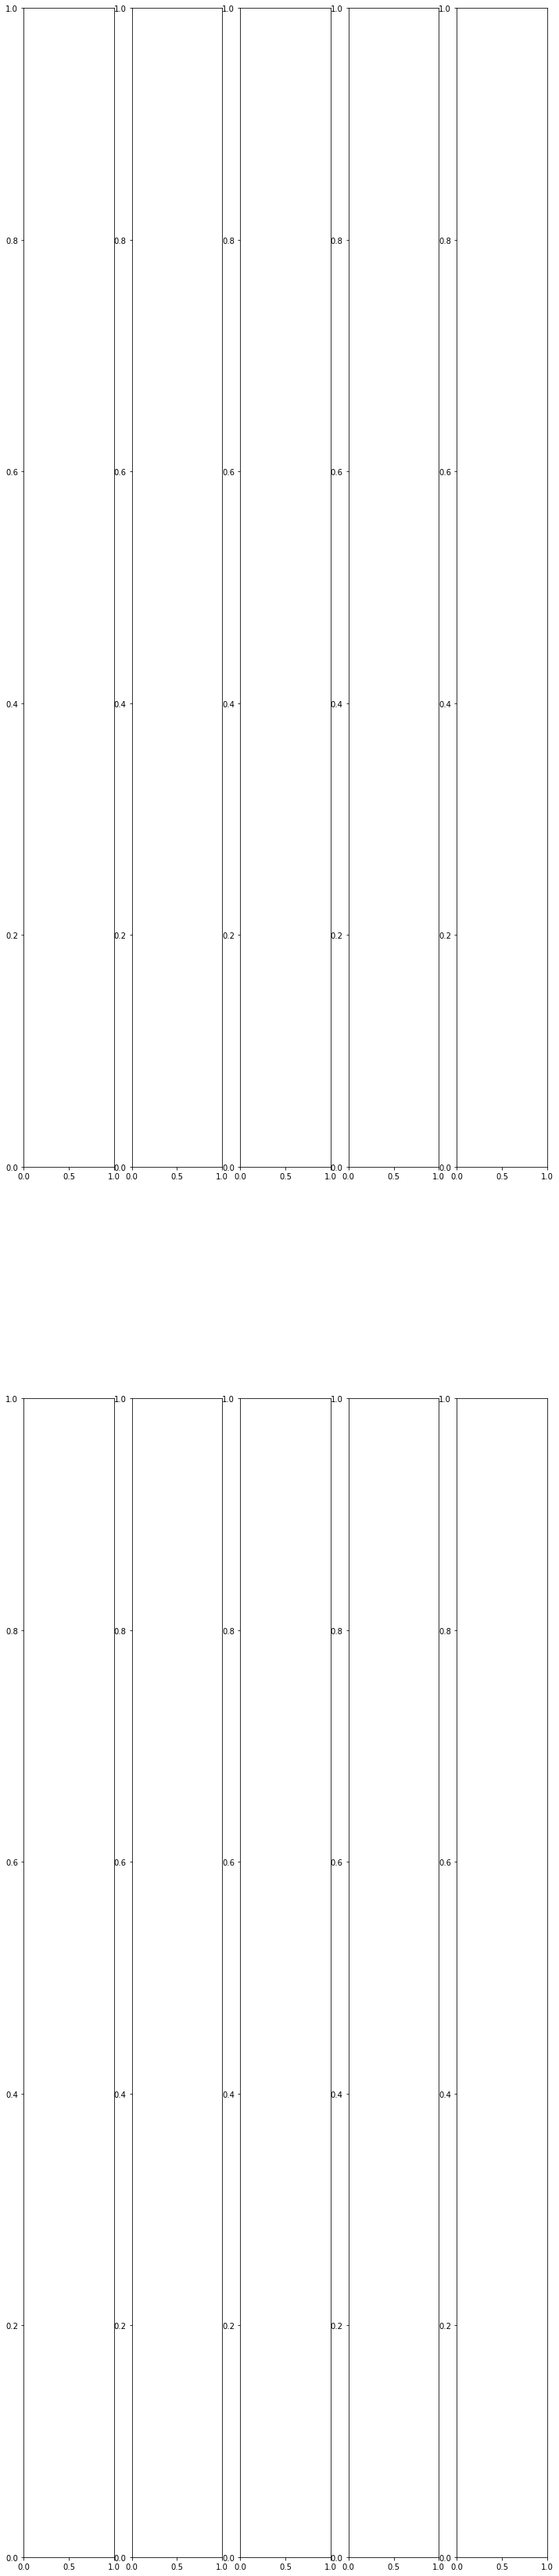

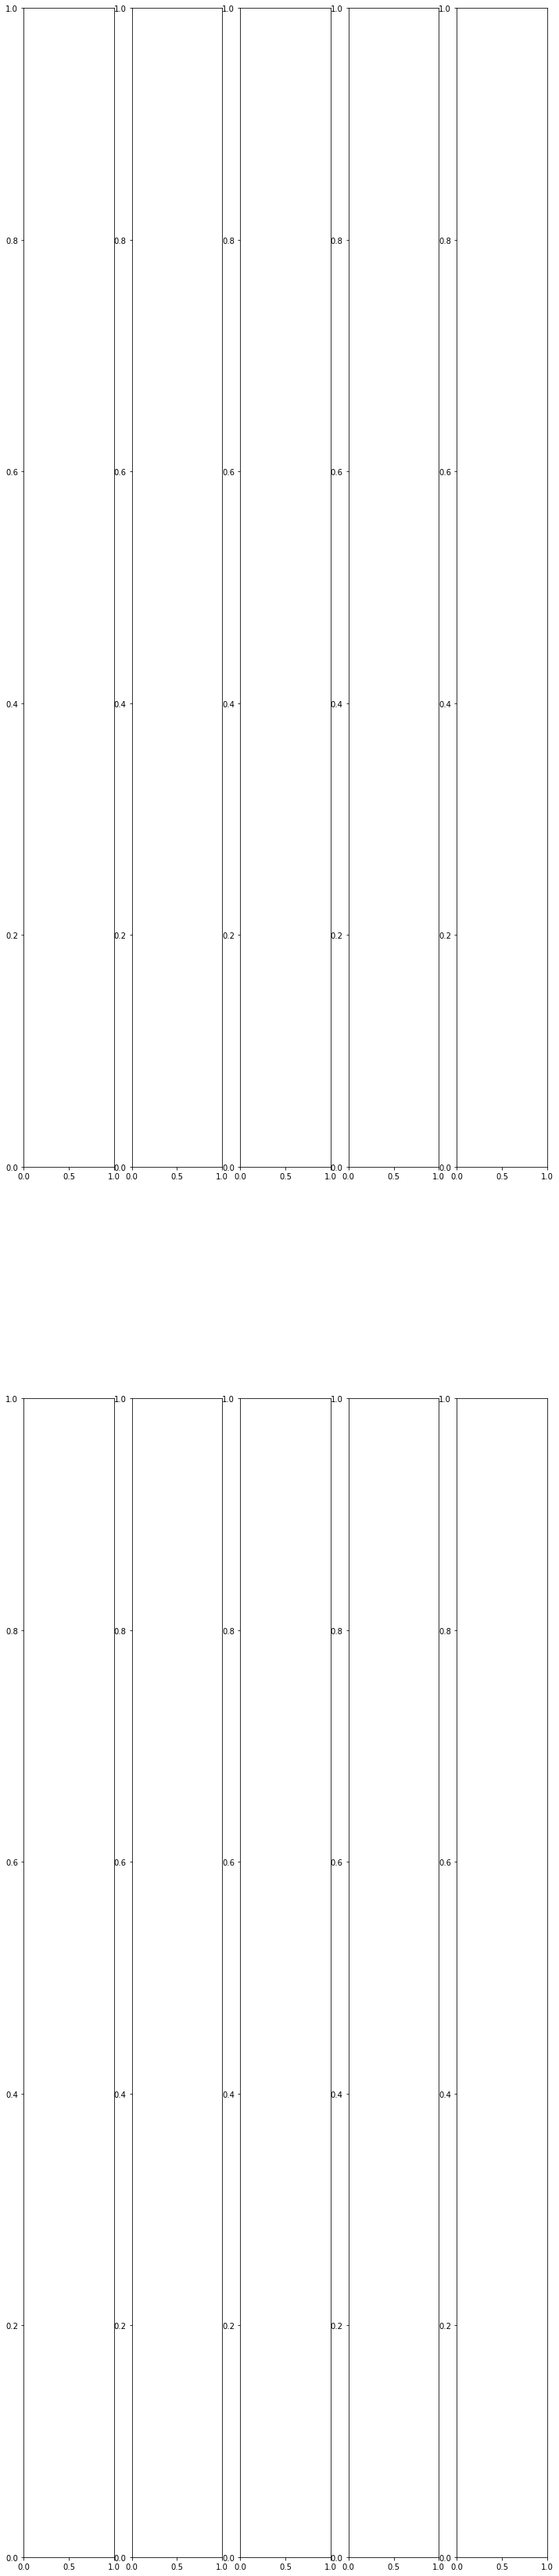

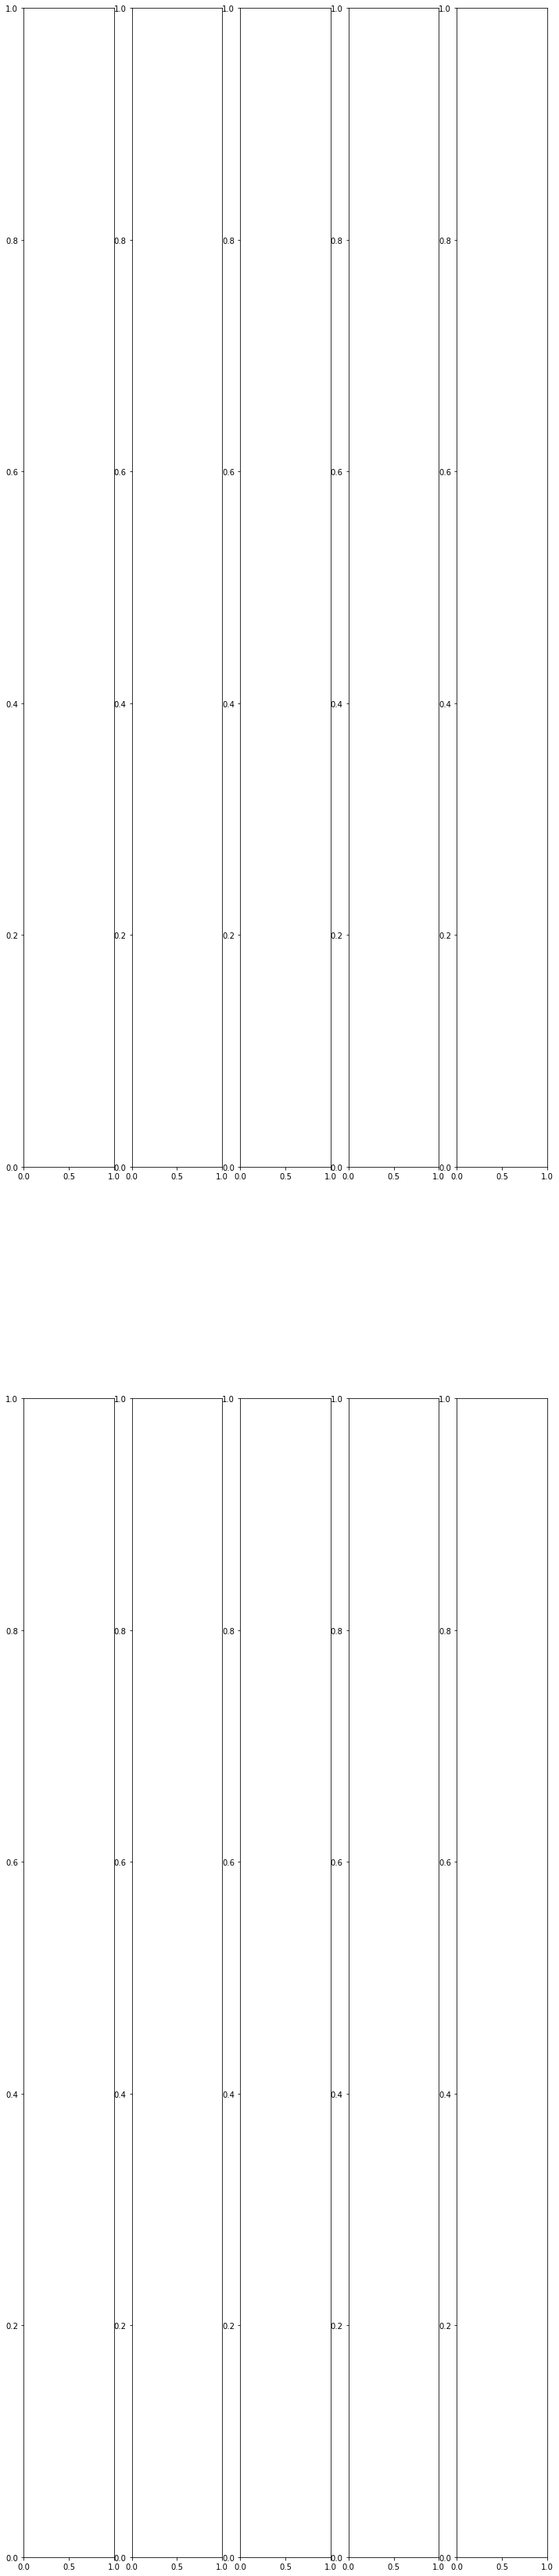

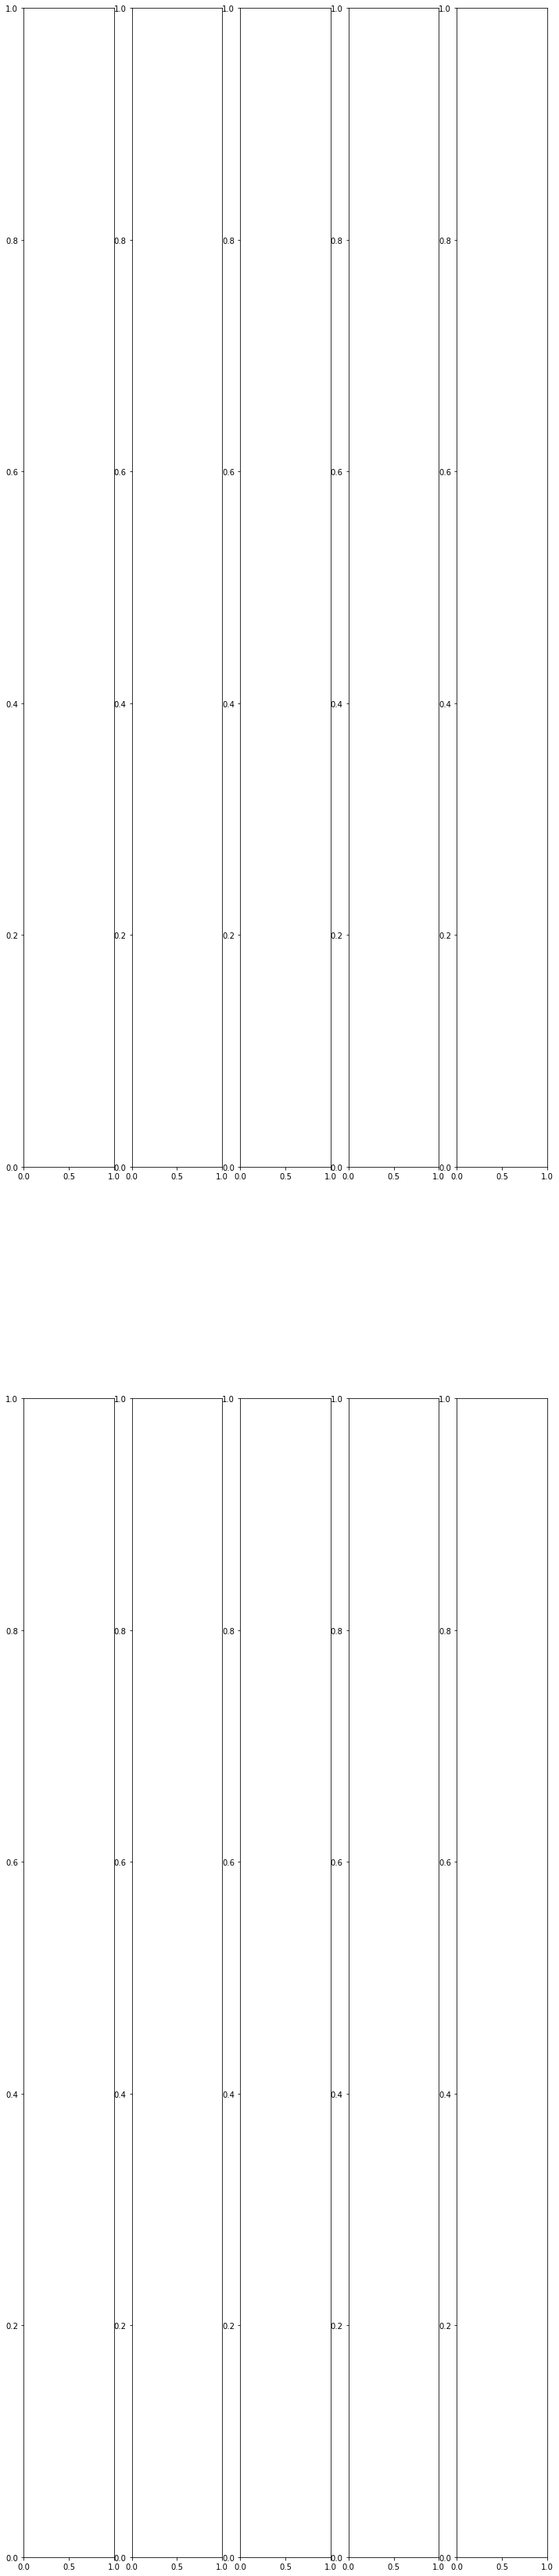

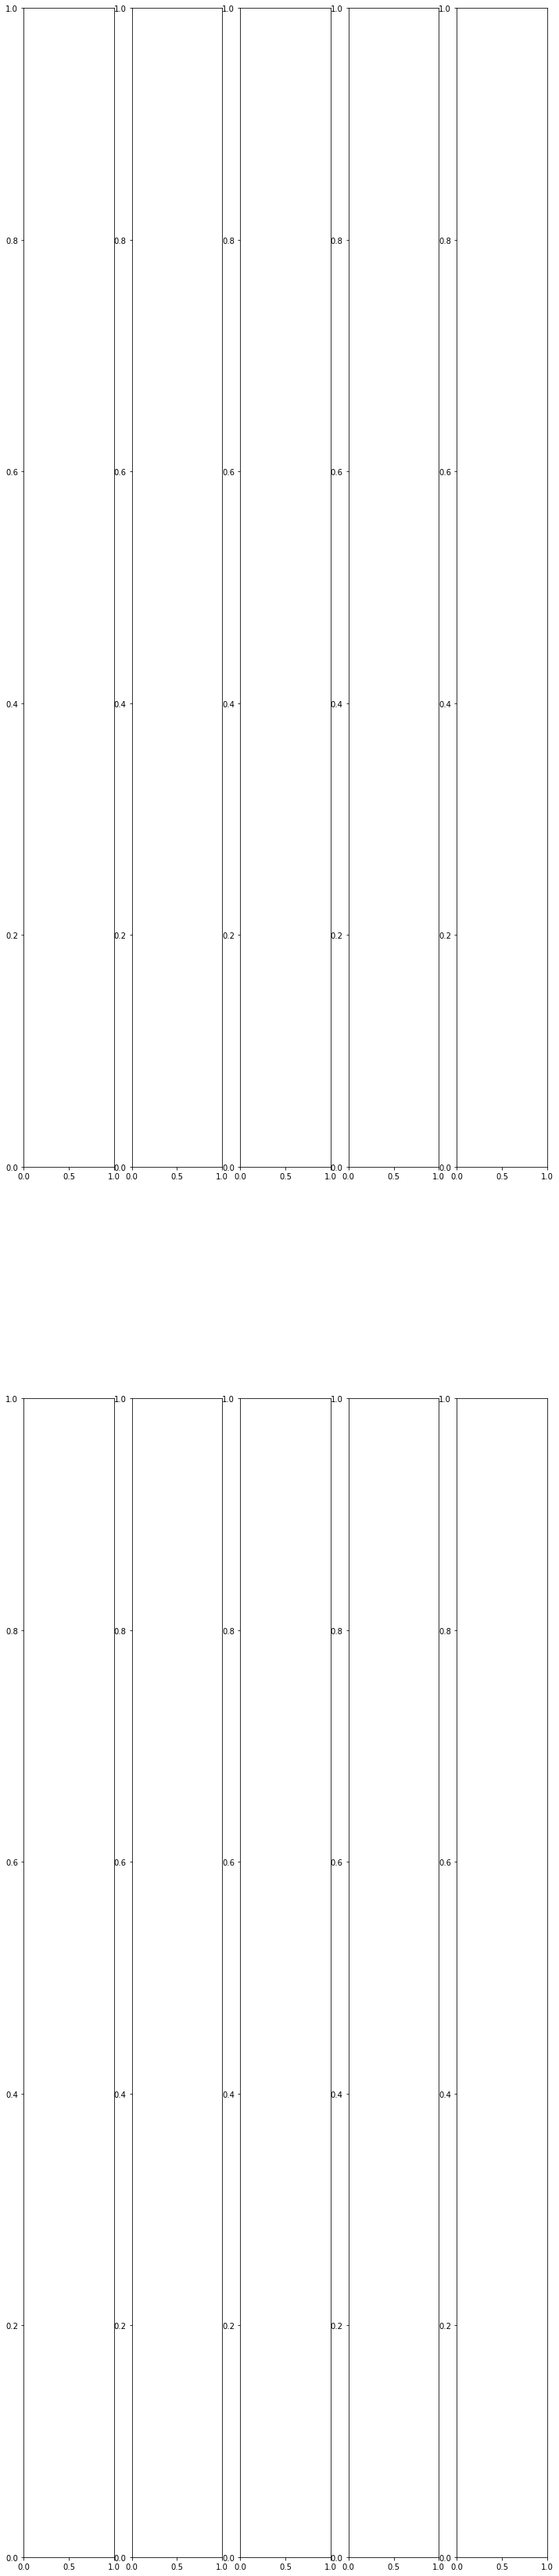

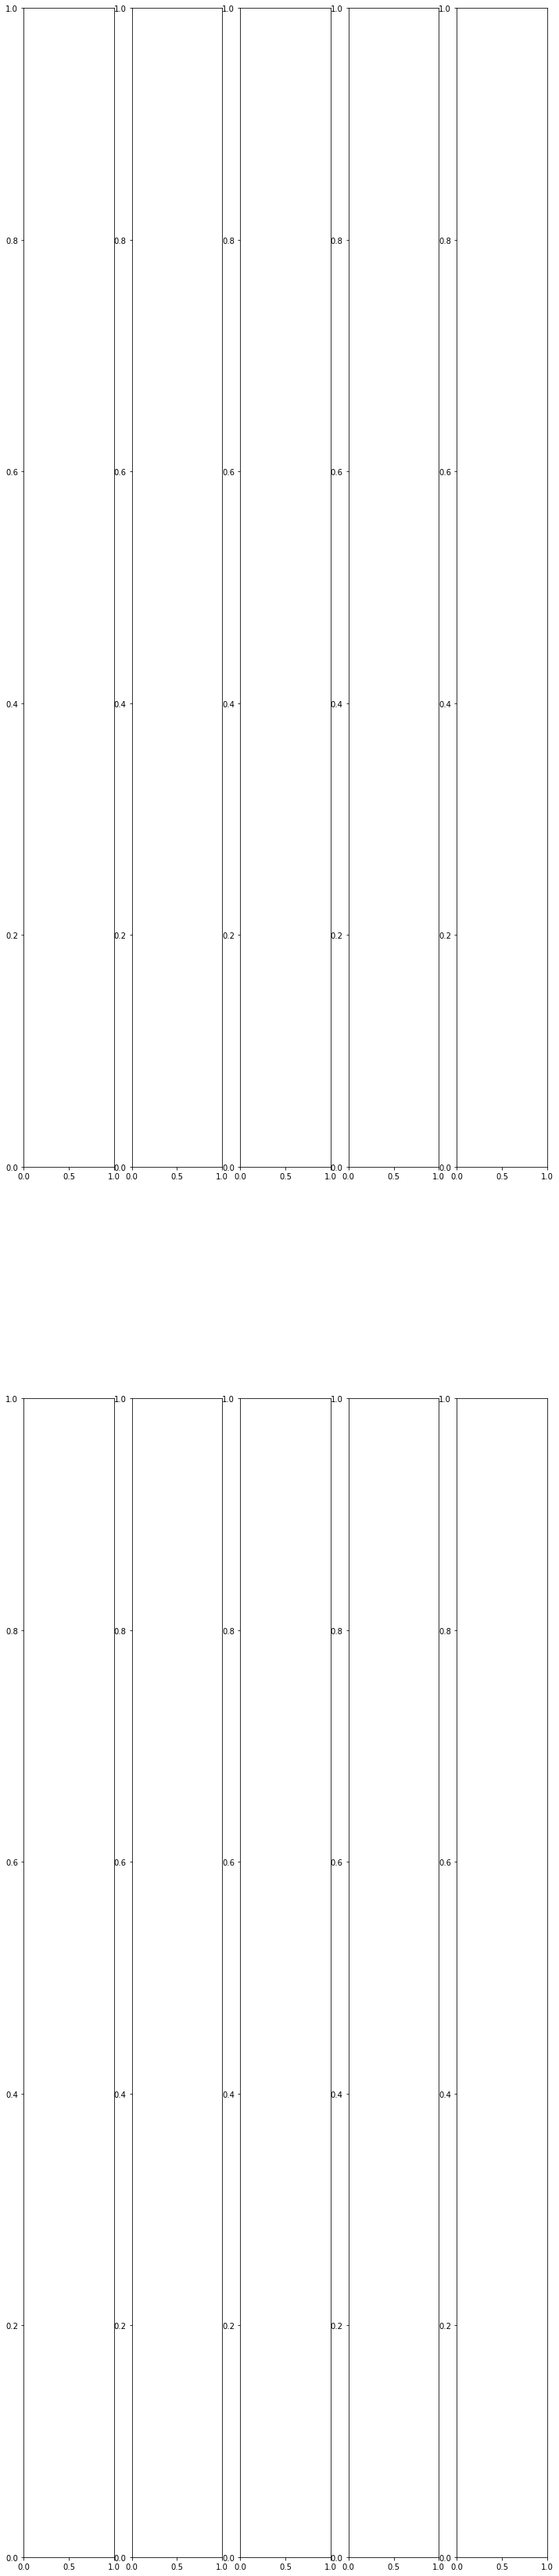

In [59]:
pos_img_cnt = 0
neg_img_cnt = 0
img_flag = True
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            
            
            fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (12,60))
            
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                if pos_img_cnt < 5:
                                    print('here')
                                    ax[0][pos_img_cnt].imshow(resized)
                                    #plt.imshow(resized)
                                    #plt.show()
                                    pos_img_cnt += 1
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                if neg_img_cnt < 5:
                                    print('here2')
                                    ax[1][neg_img_cnt].imshow(resized)
                                    #plt.imshow(resized)
                                    #plt.show()
                                    neg_img_cnt+=1
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if img_flag and neg_img_cnt >= 5 and pos_img_cnt >=5:
                        img_flag = False
                        plt.show()
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

In [11]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [12]:
X_new.shape

(30229, 224, 224, 3)

In [13]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [14]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [16]:
X= vggmodel.layers[-2].output

In [17]:
predictions = Dense(2, activation="softmax")(X)

In [18]:
model_final = Model(input = vggmodel.input, output = predictions)

/home/lab405b/anaconda3/envs/jupyter_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [19]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001)

In [20]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [21]:
model_final.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [23]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [24]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [25]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [26]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(27206, 224, 224, 3) (3023, 224, 224, 3) (27206, 2) (3023, 2)


In [27]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [28]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [29]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [31]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 5, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

Epoch 1/5
10/10 [==============================] - 271s 27s/step - loss: 0.1790 - accuracy: 0.9406 - val_loss: 0.0926 - val_accuracy: 0.9531

Epoch 00001: val_loss improved from 0.10044 to 0.09256, saving model to ieeercnn_vgg16_1.h5
Epoch 2/5
10/10 [==============================] - 263s 26s/step - loss: 0.2406 - accuracy: 0.9156 - val_loss: 0.1778 - val_accuracy: 0.9844

Epoch 00002: val_loss did not improve from 0.09256
Epoch 3/5
10/10 [==============================] - 263s 26s/step - loss: 0.2298 - accuracy: 0.9094 - val_loss: 0.1005 - val_accuracy: 0.9375

Epoch 00003: val_loss did not improve from 0.09256
Epoch 4/5
10/10 [==============================] - 262s 26s/step - loss: 0.1322 - accuracy: 0.9656 - val_loss: 0.4598 - val_accuracy: 0.9062

Epoch 00004: val_loss did not improve from 0.09256
Epoch 5/5
10/10 [==============================] - 263s 26s/step - loss: 0.1379 - accuracy: 0.9688 - val_loss: 0.3934 - val_accuracy: 0.9688

Epoch 00005: val_loss did not improve from 0.

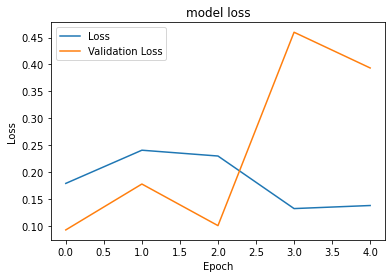

<Figure size 432x288 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

not plane


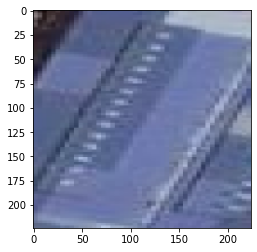

In [33]:
im = X_test[1600]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

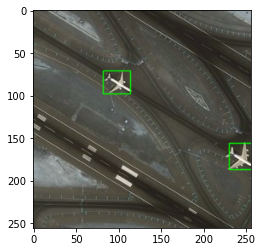

In [42]:
z=0
flag = True
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        if flag:
            flag = False
            z += 1
            img = cv2.imread(os.path.join(path,i))
            ss.setBaseImage(img)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = img.copy()
            for e,result in enumerate(ssresults):
                if e < 2000:
                    x,y,w,h = result
                    timage = imout[y:y+h,x:x+w]
                    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                    img = np.expand_dims(resized, axis=0)
                    out= model_final.predict(img)
                    if out[0][0] > 0.65:
                        cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
            plt.figure()
            plt.imshow(imout)
        else:
            break;